This notebook runs the experiment for SabreSwap v0.20 and SabreLayout v0.20


In [1]:
from qiskit.transpiler.passes.routing.sabre_swap_v020_lookahead_new import SabreSwap
from qiskit.transpiler.passes.layout.sabre_layout_v020 import SabreLayout
from ulti.circuits import get_circuit_list, sort_circuits_by_depth
from ulti.coupling_maps import file_to_coupling_map
from ulti.pass_managers import generate_pass_managers, transpiled_data
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt
import random
random.seed(42)
import os

In [2]:
# Variables to change
qc_name = "ghz_2-127"
#qc_name = "size5_depth_10-500"

experiment_name = "sabre_depth_new_3_5"
version = "20" # version for the routing pass after _v0.
lp_name = "sabre_0.20"
cp_name = "hex_127"

fast_layout = False

In [3]:
num_shots = 5
rp = SabreSwap
lp = SabreLayout
cm = file_to_coupling_map(f'coupling_maps/{cp_name}.txt')
pm = generate_pass_managers(num_shots, rp, lp, cm, fast_layout=fast_layout)


rp_name = experiment_name + "_v0." + version
qc_list = get_circuit_list([f'circuits/{qc_name}/'])
qc_list = sort_circuits_by_depth(qc_list)


csv_file_path = f'data/{qc_name}/{experiment_name}_v0{version}.csv'
directory = f'data/{qc_name}'
if not os.path.exists(directory):
        os.makedirs(directory)

In [4]:
data_list = []
for qc_idx, qc in enumerate(qc_list):
    data = transpiled_data(qc, pm)
    data['routing pass'] = rp_name
    data['layout pass'] = lp_name
    data['coupling map'] = cp_name
    data['circuit label'] = qc_idx
    data_list.append(data)

    print(f"Finished {qc_idx}")
print("Finished all")

Finished 0
Finished 1
Finished 2
Finished 3


KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame(data_list)
df.to_csv(csv_file_path, index=False)
df

,best_data,std_dev,routing pass,layout pass,coupling map,circuit label
0,"{'depth': 2, 'depth_ratio': 1.0, 'time': 0.023...","{'depth': 0, 'depth_ratio': 0, 'time': 0.00113...",sabre_depth_new_1_5_v0.20,sabre_0.20,hex_127,0
1,"{'depth': 3, 'depth_ratio': 1.0, 'time': 0.018...","{'depth': 0, 'depth_ratio': 0, 'time': 0.00047...",sabre_depth_new_1_5_v0.20,sabre_0.20,hex_127,1
2,"{'depth': 6, 'depth_ratio': 1.5, 'time': 0.018...","{'depth': 0.4899, 'depth_ratio': 0.1225, 'time...",sabre_depth_new_1_5_v0.20,sabre_0.20,hex_127,2
3,"{'depth': 7, 'depth_ratio': 1.4, 'time': 0.019...","{'depth': 0.4899, 'depth_ratio': 0.09798, 'tim...",sabre_depth_new_1_5_v0.20,sabre_0.20,hex_127,3
4,"{'depth': 8, 'depth_ratio': 1.33, 'time': 0.02...","{'depth': 2.4, 'depth_ratio': 0.4, 'time': 0.0...",sabre_depth_new_1_5_v0.20,sabre_0.20,hex_127,4
...,...,...,...,...,...,...
115,"{'depth': 363, 'depth_ratio': 2.95, 'time': 0....","{'depth': 20.22, 'depth_ratio': 0.1623, 'time'...",sabre_depth_new_1_5_v0.20,sabre_0.20,hex_127,115
116,"{'depth': 368, 'depth_ratio': 2.97, 'time': 0....","{'depth': 14.75, 'depth_ratio': 0.1204, 'time'...",sabre_depth_new_1_5_v0.20,sabre_0.20,hex_127,116
117,"{'depth': 374, 'depth_ratio': 2.99, 'time': 0....","{'depth': 7.2, 'depth_ratio': 0.05865, 'time':...",sabre_depth_new_1_5_v0.20,sabre_0.20,hex_127,117
118,"{'depth': 395, 'depth_ratio': 3.13, 'time': 0....","{'depth': 8.854, 'depth_ratio': 0.06986, 'time...",sabre_depth_new_1_5_v0.20,sabre_0.20,hex_127,118


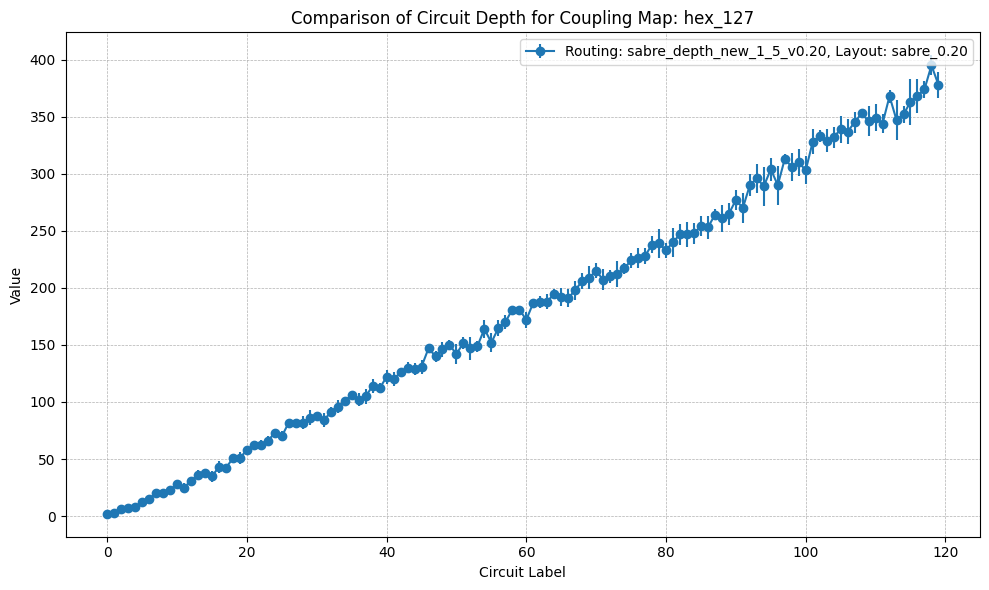

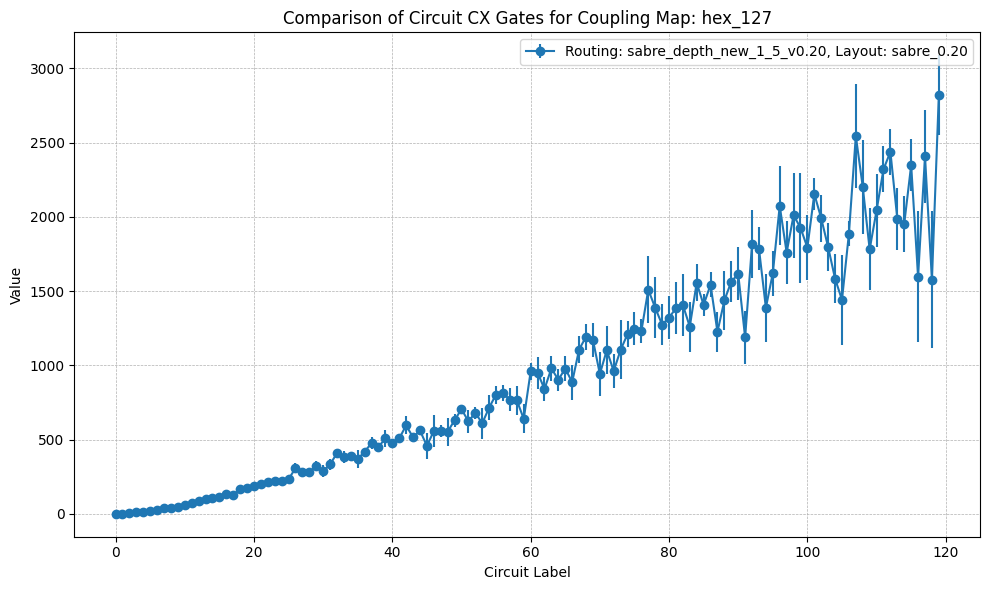

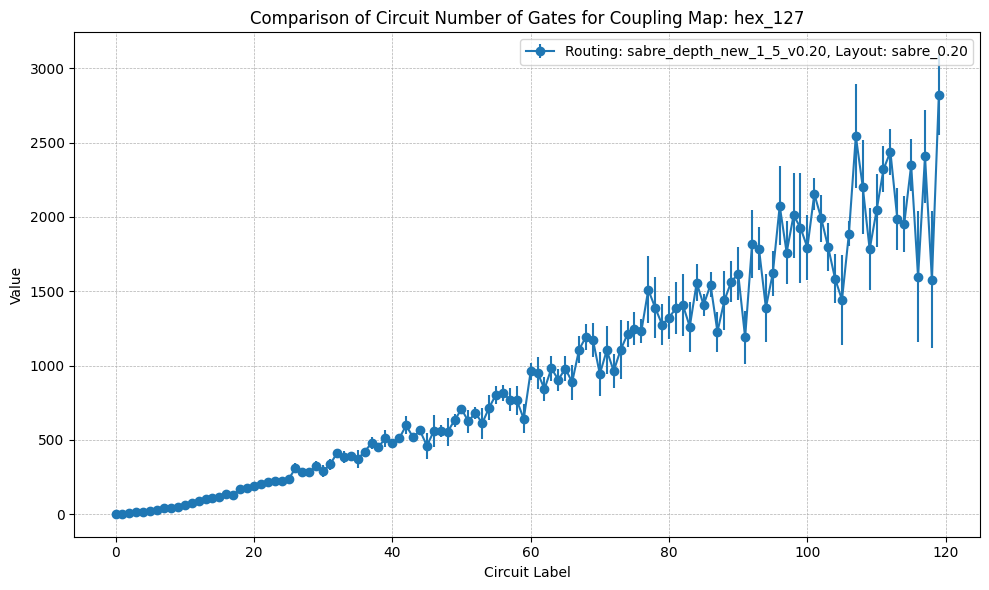

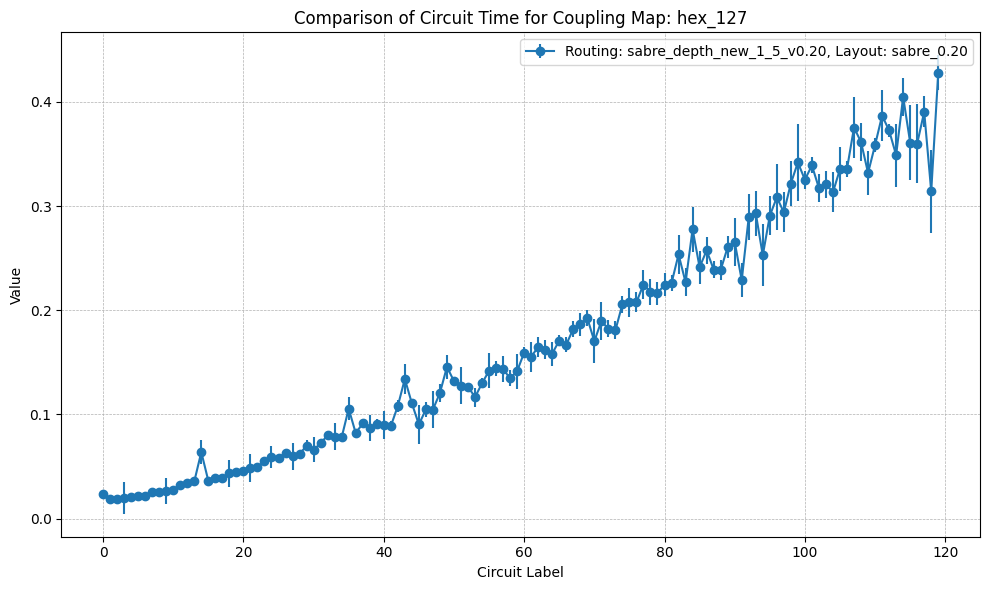

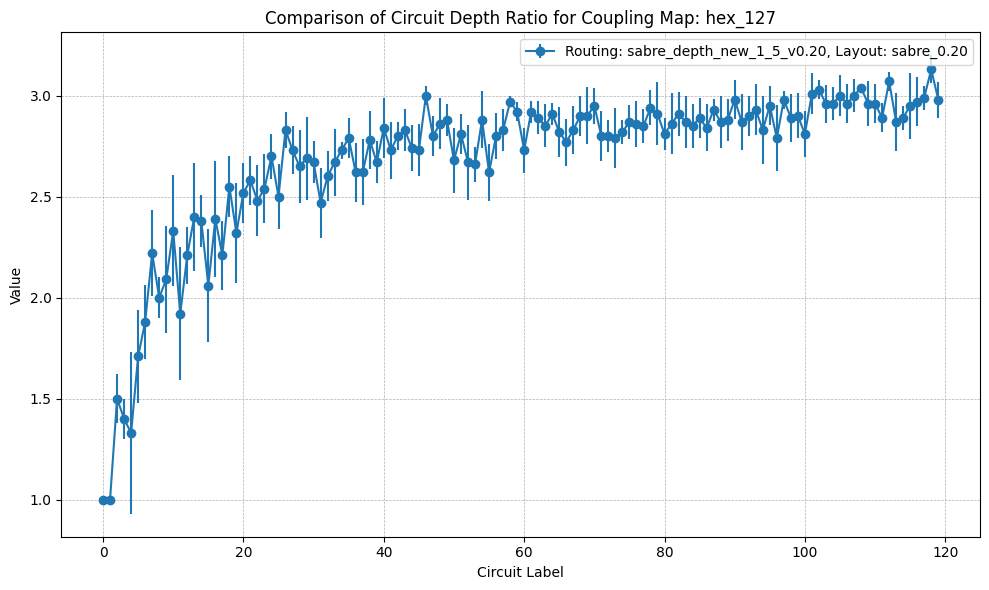

In [ ]:
data = pd.read_csv(csv_file_path)

# Convert the string representation of dictionaries into actual dictionaries
data['best_data'] = data['best_data'].apply(literal_eval)
data['std_dev'] = data['std_dev'].apply(literal_eval)

# Extract the data from the 'best_data' and 'std_dev' columns and add them to the DataFrame
for col in ['depth', 'depth_ratio', 'time', 'cx_gates', 'num_gates']:
    data[f"best_{col}"] = data['best_data'].apply(lambda x: x[col])
    data[f"std_dev_{col}"] = data['std_dev'].apply(lambda x: x[col])

metrics = [
    ("depth", "Depth"),
    ("cx_gates", "CX Gates"),
    ("num_gates", "Number of Gates"),
    ("time", "Time"),
    ("depth_ratio", "Depth Ratio")
]

unique_routing_layout_combinations = data[['routing pass', 'layout pass']].drop_duplicates().values

for metric, label in metrics:
    plt.figure(figsize=(10, 6))
    for routing_pass, layout_pass in unique_routing_layout_combinations:
        subset = data[(data['routing pass'] == routing_pass) & (data['layout pass'] == layout_pass)]
        plt.errorbar(subset['circuit label'], subset[f"best_{metric}"], yerr=subset[f"std_dev_{metric}"], fmt='o-', label=f'Routing: {routing_pass}, Layout: {layout_pass}')
    plt.xlabel('Circuit Label')
    plt.ylabel('Value')
    plt.title(f'Comparison of Circuit {label} for Coupling Map: {data["coupling map"].iloc[0]}')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    #plt.savefig(f"data/graphs/{qc_name}/{experiment_name}_v0{version}/{label.replace(' ', '_').lower()}.png")
    plt.show()
    plt.close()